# Data Mining Project
## Discover and describe aeras of interest and events from geo-located data.
### Team:
- **SCHLEE Adam**
- **KUSNO Louis**

## Imports

In [67]:
# installation of required libraries and dependencies
# numeric calculations
! pip install numpy
# data frames 
! pip install pandas
# machine learning algorithms 
! pip install scikit-learn
! pip install scipy
# plotting 
! pip install matplotlib
! pip install folium
# ! pip install plotly
# ! pip install seaborn
# ! pip install plotly-express
# ! pip install chart-studio
# web app library 
# ! pip install streamlit
# # association rules
# ! pip install mlxtend

# ! pip install nbformat

In [68]:
# load pandas to deal with the data
import pandas as pd
# plotting
import matplotlib.pyplot as plt
# folium for maps
import folium as fl
# numpy
import numpy as np
# scaler
from sklearn.preprocessing import StandardScaler
# k-means
from sklearn.cluster import KMeans
# silhouette scores
from sklearn.metrics import silhouette_score, silhouette_samples
# dendrogram
from scipy.cluster.hierarchy import dendrogram
# agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
# DBSCAN
from sklearn.cluster import DBSCAN

In [132]:
data = pd.read_table("data/dataset.csv", sep=",")
data = data.sample(n=20000, random_state=45).reset_index(drop=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   user                20000 non-null  object 
 2   lat                 20000 non-null  float64
 3   long                20000 non-null  float64
 4   tags                14972 non-null  object 
 5   title               18166 non-null  object 
 6   date_taken_minute   20000 non-null  int64  
 7   date_taken_hour     20000 non-null  int64  
 8   date_taken_day      20000 non-null  int64  
 9   date_taken_month    20000 non-null  int64  
 10  date_taken_year     20000 non-null  int64  
 11  date_upload_minute  20000 non-null  int64  
 12  date_upload_hour    20000 non-null  int64  
 13  date_upload_day     20000 non-null  int64  
 14  date_upload_month   20000 non-null  int64  
 15  date_upload_year    20000 non-null  int64  
dtypes: f

,id,user,lat,long,tags,title,date_taken_minute,date_taken_hour,date_taken_day,date_taken_month,date_taken_year,date_upload_minute,date_upload_hour,date_upload_day,date_upload_month,date_upload_year
0,5765921863,63168313@N06,45.770153,4.835496,"tango,nuitblanche,claudiacodega,estebanmoreno,...",20100321LYON_TDS054,41,0,28,5,2011,41,0,28,5,2011
1,8263239141,68759780@N07,45.767298,4.835969,NaN,Roman-Tyca,9,23,6,12,2012,59,14,11,12,2012
2,5114133224,52742240@N05,45.758728,4.830808,"lyon,police,bellecour,jeunes,incidents,retrait...",19:00h,47,17,22,10,2009,5,13,25,10,2010
3,15145788336,95921949@N04,45.757837,4.832183,NaN,70ième anniversaire de la libération de Lyon,18,17,3,9,2014,56,18,7,9,2014
4,14943776195,32215553@N02,45.767148,4.833501,"lumix,lyon,panasonic,throughthewindow,placedes...",DMC-FZ1000 - à travers une vitre,18,17,11,8,2014,10,10,17,8,2014


> ### Affichage de la carte et des points avec Folium 

In [133]:
# Affichage de la carte et des points avec Folium 

# Création de la carte
map = fl.Map(location=[48.8566, 2.3522], zoom_start=12)

# Ajout des points sur la carte

for i in range(0, 5000):
    fl.Circle(
        location=[data.loc[i]['lat'], data.loc[i]['long']],
        radius=10,
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(map)

# Recentrer la carte
map.fit_bounds(map.get_bounds())

# Affichage de la carte
map.save("map.html")

> ### Clustering des points sur la map avec K-Means

#### Préparation des données pour le clustering

In [134]:
# select columns to keep
keep_col = ['lat', 'long']
df_clustering = data[keep_col]

#### Scaling des données

In [182]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)
# show
print(scaled_data)
# create a DataFrame
scaled_data_df = pd.DataFrame(data=scaled_data, columns=df_clustering.columns)
scaled_data_df.head()

[[ 0.05431701 -0.13172916]
 [-0.04520164 -0.11678387]
 [-0.34393189 -0.27985494]
 ...
 [ 0.14407552 -0.10831593]
 [-1.29847439 -3.31930874]
 [-0.27348454 -0.39477248]]


,lat,long
0,0.054317,-0.131729
1,-0.045202,-0.116784
2,-0.343932,-0.279855
3,-0.374990,-0.236409
4,-0.050430,-0.194765


#### Recherche du k optimal

##### Avec la méthode du Elbow

Applying k-means with 1/500 clusters
Applying k-means with 2/500 clusters
Applying k-means with 3/500 clusters
Applying k-means with 4/500 clusters
Applying k-means with 5/500 clusters
Applying k-means with 6/500 clusters
Applying k-means with 7/500 clusters
Applying k-means with 8/500 clusters
Applying k-means with 9/500 clusters
Applying k-means with 10/500 clusters
Applying k-means with 11/500 clusters
Applying k-means with 12/500 clusters
Applying k-means with 13/500 clusters
Applying k-means with 14/500 clusters
Applying k-means with 15/500 clusters
Applying k-means with 16/500 clusters
Applying k-means with 17/500 clusters
Applying k-means with 18/500 clusters
Applying k-means with 19/500 clusters
Applying k-means with 20/500 clusters
Applying k-means with 21/500 clusters
Applying k-means with 22/500 clusters
Applying k-means with 23/500 clusters
Applying k-means with 24/500 clusters
Applying k-means with 25/500 clusters
Applying k-means with 26/500 clusters
Applying k-means with

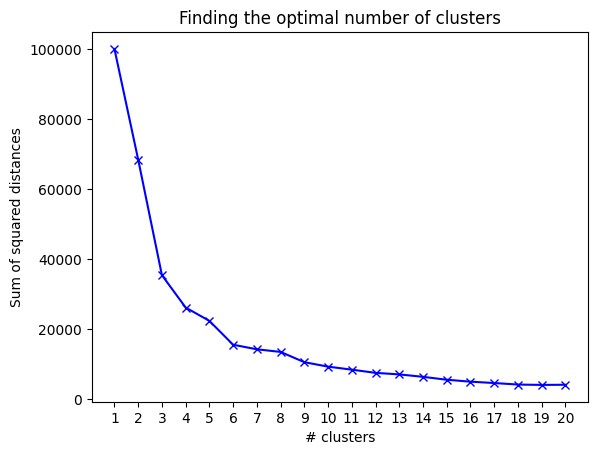

In [107]:
# range of k
range_k = range(1, len(scaled_data_df)//1000)
# a list of intertia scores
inertias = []

# vary k and apply k-means
for i in range_k:
    # apply k-means with i clusters
    print(f"Applying k-means with {i}/{len(scaled_data_df)//100} clusters")
    kmeans = KMeans(n_clusters=i, init='k-means++')
    # fit scaled data 
    kmeans.fit(scaled_data_df)
    # append inertia to the list
    inertias.append(kmeans.inertia_)

# visualise
n = 20
xticks_new = np.arange(1, n+1)
plt.plot(xticks_new, inertias[0:n], 'bx-')
plt.title('Finding the optimal number of clusters')
plt.xticks(xticks_new)
plt.xlabel('# clusters')
plt.ylabel('Sum of squared distances')
plt.show()

#### Application de K-Means 

In [108]:
# number of clusters 
k = 100
# create a model
kmeans = KMeans(n_clusters=k, init='k-means++')
# fit scaled data
kmeans.fit(scaled_data_df)

# associated cluster labels
labels = kmeans.labels_
print(f"k-means labels: {labels}")

# sum of squared distances
inertia = kmeans.inertia_
print(f"Sum of squared distances: {inertia}")



k-means labels: [ 0 86 90 ... 41 41 34]
Sum of squared distances: 474.27923309674304


#### Affichage des clusters sur la maps

In [109]:
# Affichage des clusters sur la map avec une couleur différente pour chaque cluster

# add cluster labels to data_cleaned
data['cluster'] = labels

# create a map
map = fl.Map(location=[48.8566, 2.3522], zoom_start=12)

# style of the map
fl.TileLayer('Cartodb dark_matter').add_to(map)

# add points to the map with different colors for each cluster
colors = [
    "red", "blue", "green", "yellow", "purple", "orange", "pink", "white", "black", "gray", "lightgray", "darkgray",
    "beige", "ivory", "cream", "darkred", "lightred", "darkblue", "lightblue", "cadetblue", "darkcadetblue",
    "darkgreen", "lightgreen", "lime", "teal", "aqua", "cyan", "magenta", "maroon", "navy", "indigo", "violet",
    "gold", "silver", "bronze", "coral", "salmon", "chocolate", "khaki", "tan", "olive", "chartreuse", "turquoise",
    "peach", "lavender", "plum", "orchid", "amber", "ruby", "sapphire", "emerald", "amethyst", "periwinkle",
    "mint", "mustard", "fuchsia", "sand", "brick", "copper", "strawberry", "raspberry", "wine", "mahogany",
    "espresso", "jade", "slate", "coal", "charcoal", "snow", "pearl", "eggshell", "sunflower", "apricot", "honey",
    "lemon", "tangerine", "blush", "rose", "skyblue", "seafoam", "midnightblue", "denim", "forestgreen", "seagreen",
    "pistachio", "caramel", "mocha", "espresso", "graphite", "obsidian", "creamwhite", "carnation", "buttercup",
    "mauve", "heather", "melon", "watermelon", "storm", "fog", "ash", "cobalt", "cerulean", "crimson", "brickred",
    "umber", "ochre", "sienna", "mandarin", "flamingo", "parrotgreen", "spearmint", "limegreen", "arcticblue",
    "desert", "sunset", "sunrise", "midday", "dusk", "twilight", "night", "day", "floralwhite"
]

for i in range(0, 9999):
    fl.Circle(
        location=[data.loc[i]['lat'], data.loc[i]['long']],
        radius=2,
        color=colors[data.loc[i]['cluster']%len(colors)],
        fill=True,
        fill_color=colors[data.loc[i]['cluster']%len(colors)],
        popup=f"Cluster: {data.loc[i]['cluster']}"
    ).add_to(map)

# recenter the map
map.fit_bounds(map.get_bounds())

# save the map
map.save("map_clusters.html")

> ### Evaluation du clustering avec le coefficient de silhouette

In [76]:
silhouette_avg = silhouette_score(scaled_data, labels, metric='euclidean')
sample_silhouette_values = silhouette_samples(scaled_data, labels, metric='euclidean')
data['silhouette kmeans'] = sample_silhouette_values

print(f"Average silhouette score: {silhouette_avg}")
print(f"Sample Silhouette values: {sample_silhouette_values}")

n_clusters = 7

Average silhouette score: 0.7002239536429753
Sample Silhouette values: [0.42988329 0.19477706 0.78784641 ... 0.69356275 0.76921374 0.76921374]


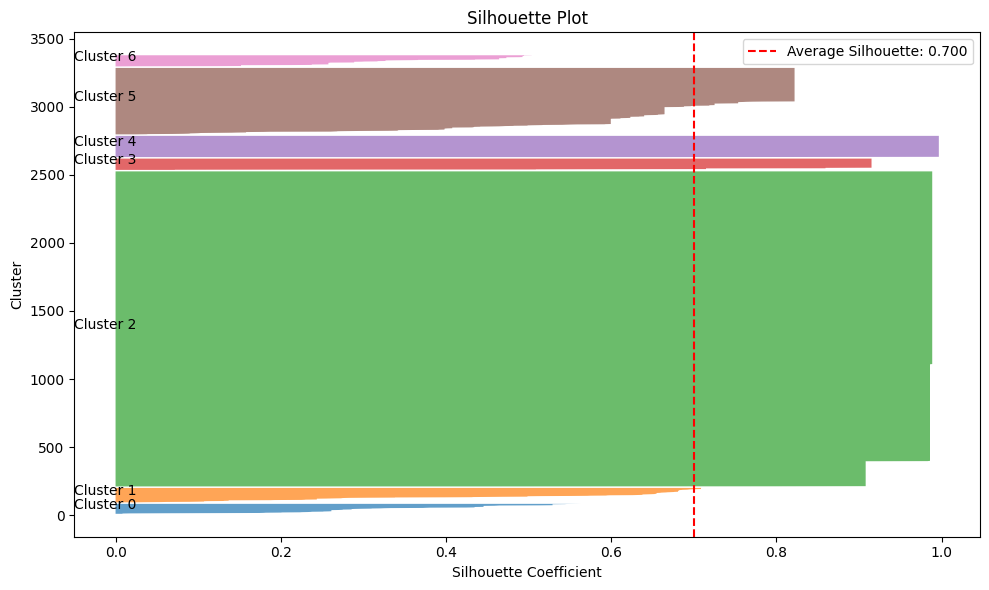

In [77]:
fig = plt.figure(figsize=(10, 6))
 
y_lower = 10
for i in range(n_clusters):
    # Get silhouette scores for cluster i
    ith_cluster_values = sample_silhouette_values[labels == i]
    ith_cluster_values.sort()
    
    size_cluster_i = ith_cluster_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    # Fill the silhouette
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_values,
                        alpha=0.7)
    
    # Label the silhouette plots
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    
    y_lower = y_upper + 10

# Add vertical line for average silhouette score
plt.axvline(x=silhouette_avg, color='red', linestyle='--', 
            label=f'Average Silhouette: {silhouette_avg:.3f}')

plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.legend(loc='best')
plt.tight_layout()

> ### Application du clustering hierarchique

In [226]:
def plot_dendrogram(model, lbls, title='Hierarchical Clustering Dendrogram', x_title='Clusters', **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([
           model.children_,
           model.distances_,
           counts
       ]).astype(float)

    fig = plt.figure(figsize=(12, 8))
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, labels=lbls, leaf_rotation=90)
    
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel('Distance')
    
    fig.show()
    
    return fig

In [227]:
def hierarchical(data, labels, metric='euclidean', linkage='average', n_clusters=None, dist_thres=None):
    model = AgglomerativeClustering(distance_threshold=dist_thres, n_clusters=n_clusters, metric=metric, linkage=linkage, compute_full_tree=True, compute_distances=True)
    model = model.fit(data)
    
    txt_title = 'Hierarchical Clustering Dendrogram' + ', linkage: ' + linkage
    f = plot_dendrogram(model=model, lbls=labels, title=txt_title, x_title='Clusters')
    
    return model, f

C:\Users\aschl\AppData\Local\Temp\ipykernel_20088\2615477095.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Linkage: complete, silhouette score: 0.4494834180215519


C:\Users\aschl\AppData\Local\Temp\ipykernel_20088\2615477095.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Linkage: average, silhouette score: 0.516344780107527


C:\Users\aschl\AppData\Local\Temp\ipykernel_20088\2615477095.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Linkage: single, silhouette score: 0.3636003358272987


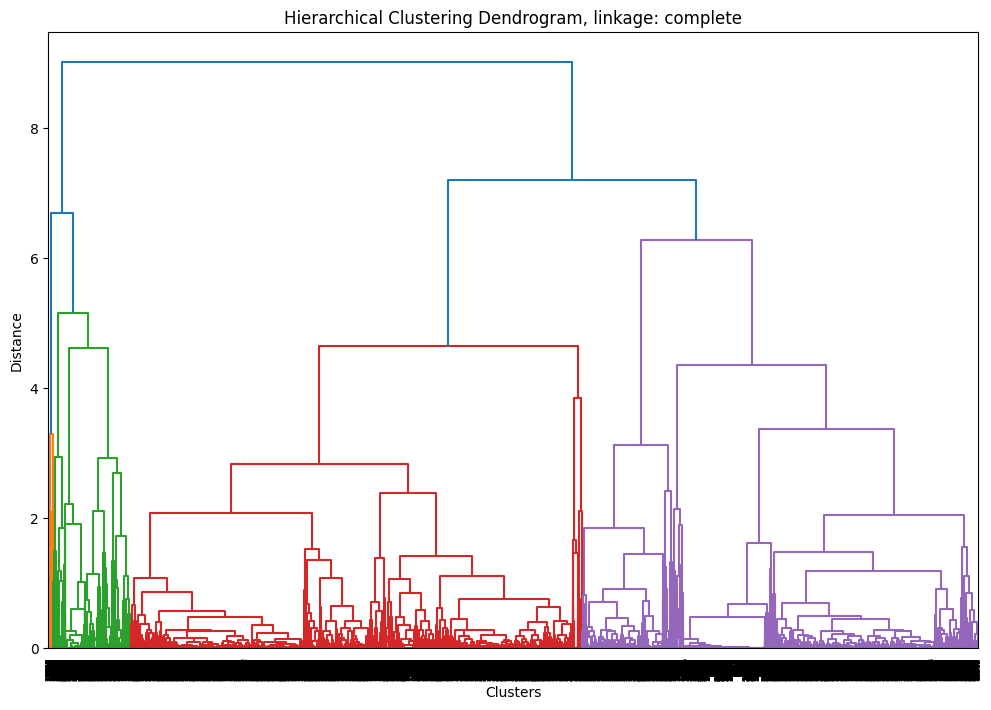

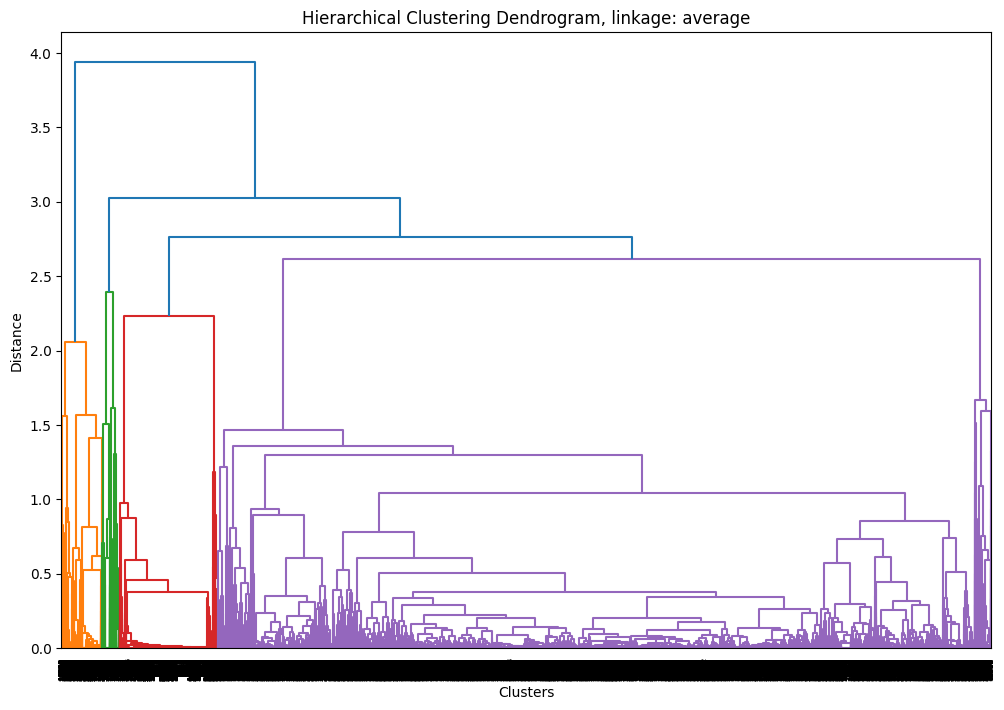

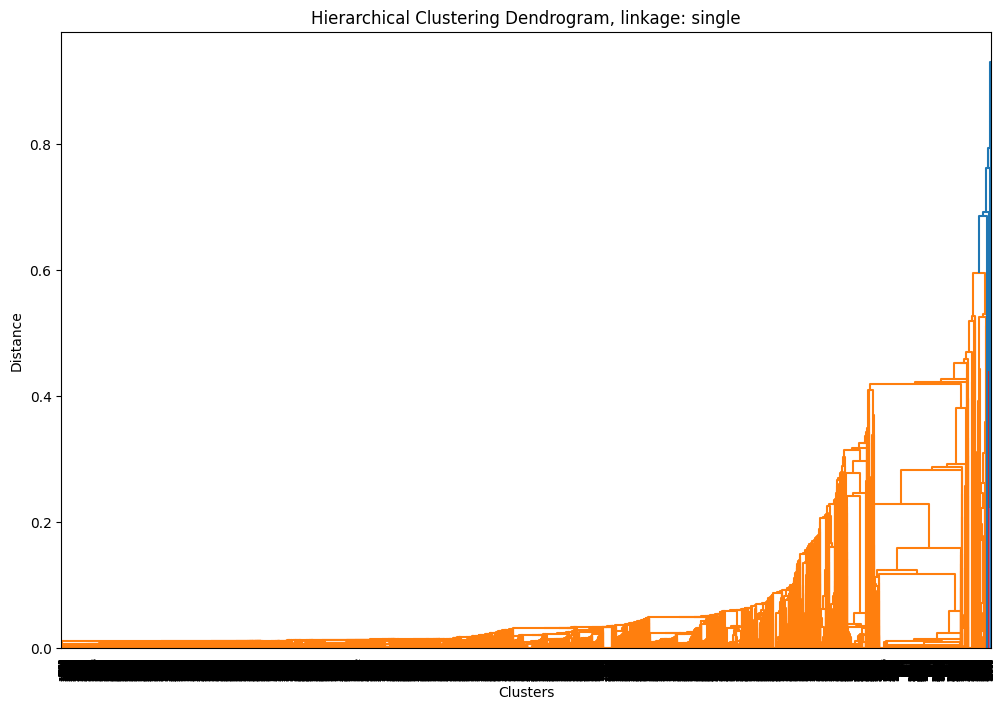

In [228]:
linkage = ['complete', 'average', 'single']

for link in linkage:
    m, f = hierarchical(scaled_data, list(scaled_data_df.index), metric='euclidean', linkage=link, n_clusters=50, dist_thres=None)
    
    data['cluster ' + link] = m.labels_
    silhouette_avg = silhouette_score(scaled_data, m.labels_, metric='euclidean')
    sample_silhouette_values = silhouette_samples(scaled_data, m.labels_, metric='euclidean')
    data['silhouette ' + link] = sample_silhouette_values
    
    print(f"Linkage: {link}, silhouette score: {silhouette_avg}")

#### Afficher sur la map les clusters obtenus avec le clustering hierarchique

In [229]:
# create a map
map = fl.Map(location=[48.8566, 2.3522], zoom_start=12)

# style of the map
fl.TileLayer('Cartodb dark_matter').add_to(map)

# add points to the map with different colors for each cluster
for i in range(0, 9999):
    fl.Circle(
        location=[data.loc[i]['lat'], data.loc[i]['long']],
        radius=2,
        color=colors[data.loc[i]['cluster average']%len(colors)],
        fill=True,
        fill_color=colors[data.loc[i]['cluster average']%len(colors)],
        popup=f"Cluster: {data.loc[i]['cluster average']}"
    ).add_to(map)

# recenter the map
map.fit_bounds(map.get_bounds())

# save the map
map.save("map_clusters_average.html")

for i in range(0, 9999):
    fl.Circle(
        location=[data.loc[i]['lat'], data.loc[i]['long']],
        radius=2,
        color=colors[data.loc[i]['cluster complete']%len(colors)],
        fill=True,
        fill_color=colors[data.loc[i]['cluster complete']%len(colors)],
        popup=f"Cluster: {data.loc[i]['cluster complete']}"
    ).add_to(map)

# recenter the map
map.fit_bounds(map.get_bounds())

# save the map
map.save("map_clusters_complete.html")

for i in range(0, 9999):
    fl.Circle(
        location=[data.loc[i]['lat'], data.loc[i]['long']],
        radius=2,
        color=colors[data.loc[i]['cluster single']%len(colors)],
        fill=True,
        fill_color=colors[data.loc[i]['cluster single']%len(colors)],
        popup=f"Cluster: {data.loc[i]['cluster single']}"
    ).add_to(map)

# recenter the map
map.fit_bounds(map.get_bounds())

# save the map
map.save("map_clusters_single.html")

> ### Application de DBSCAN

In [255]:
# Create ranges of epsilon and min_samples to test
eps_range = np.arange(0.008, 0.009, 0.001)
min_samples_range = range(15, 16)

# Store results
best_score = -1
best_eps = None
best_min_samples = None
scores = []

In [256]:
# Grid search
for eps in eps_range:
    print(f"Testing eps: {eps}/{eps_range[-1]}")
    for min_samples in min_samples_range:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_data)

        if len(set(labels) - {-1}) < 2:  # Vérifie qu'il y a au moins deux clusters sans tenir compte du bruit
            continue
            
        # Calculate silhouette score
        score = silhouette_score(scaled_data, labels)
        print(f"Score: {score}")
        scores.append({'eps': eps, 'min_samples': min_samples, 'score': score})
        
        # Update best parameters if score is better
        if score > best_score:
            print(f"New best score: {score}")
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

# Convert scores to DataFrame for easier analysis
scores_df = pd.DataFrame(scores)

Testing eps: 0.008/0.008
Score: -0.06558855019292306
New best score: -0.06558855019292306


In [257]:
print(f"Best score = {best_score}, best_eps = {best_eps}, best_min_samples = {min_samples}")

Best score = -0.06558855019292306, best_eps = 0.008, best_min_samples = 15


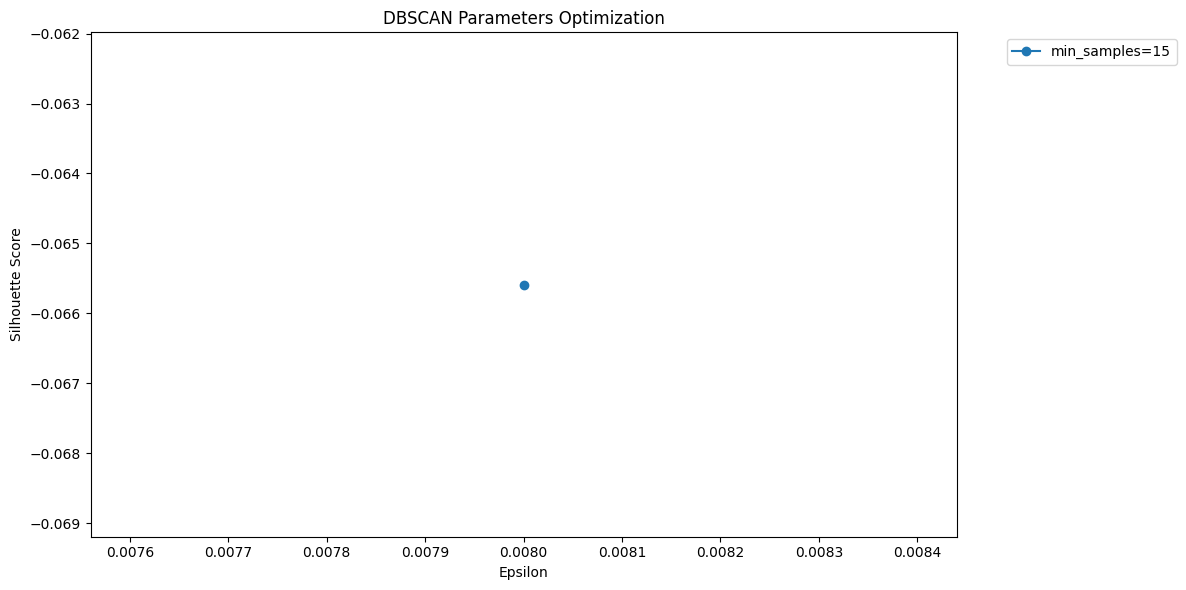

In [258]:
plt.figure(figsize=(12, 6))
for min_samples in min_samples_range:
    mask = scores_df['min_samples'] == min_samples
    plt.plot(scores_df[mask]['eps'], 
             scores_df[mask]['score'], 
             'o-', 
             label=f'min_samples={min_samples}')

plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN Parameters Optimization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [259]:
# Apply DBSCAN with best parameters
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_labels = best_dbscan.fit_predict(scaled_data)

In [260]:
# Print number of clusters and noise points
n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
n_noise = list(best_labels).count(-1)
print(f"\nNumber of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")


Number of clusters: 139
Number of noise points: 9050


In [261]:
data['cluster dbscan'] = best_labels
data['silhouette dbscan'] = silhouette_score(scaled_data, best_labels)

#### Afficher sur la map les clusters obtenus avec DBSCAN

In [262]:
# create a map
map = fl.Map(location=[48.8566, 2.3522], zoom_start=12)

# style of the map
fl.TileLayer('Cartodb dark_matter').add_to(map)

# Add points to the map with different colors for each cluster
for i in range(len(data)):  # Utiliser la taille réelle des données
    cluster = data.loc[i]['cluster dbscan']
    
    # Ignore noise points (-1)
    if cluster == -1:
        continue
    
    # Add cluster points to the map
    fl.Circle(
        location=[data.loc[i]['lat'], data.loc[i]['long']],
        radius=2,
        color=colors[cluster % len(colors)],
        fill=True,
        fill_color=colors[cluster % len(colors)],
        popup=f"Cluster: {cluster}\nTitle: {data.loc[i]['title']}"
    ).add_to(map)

# recenter the map
map.fit_bounds(map.get_bounds())

# save the map
map.save("map_clusters_dbscan.html")